In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt
import time
%matplotlib inline

def generateGaussRandom(numberOfPaths, pathLength, mySeed):
    #GenerateGaussRandom
    if mySeed:
        np.random.seed(mySeed)
    N = numberOfPaths*pathLength
    W = np.random.normal(0.0,1.0,N)
    W = W.reshape((numberOfPaths,pathLength))
    return W
    
def generateGBMPaths(W,numberOfPaths,pathLength,dt,S0=100,mu=0.0,vol=0.2):
    T  = pathLength*dt
    ST = []
    sqrtDt = np.sqrt(dt)
    for path in np.arange(numberOfPaths):
        st = S0
        for timeStep in np.arange(pathLength):
            st = st * (1 + rfr*dt + vol*sqrtDt*W[path,timeStep])
        ST.append(st)
    ST = np.array(ST)
    #print('ST:',np.mean(ST), np.std(ST),'    -     ',S0*np.exp(mu*T), np.sqrt(S0**2*np.exp(2*mu*T)*(np.exp(vol**2*T)-1)))
    return ST

def getPayoff(ST,K,oType):
    if   oType == 'Call':
        payoff = np.maximum(ST-K[0],0)
    elif oType == 'Put':
        payoff = np.maximum(K[0]-ST,0)
    elif oType == 'Straddle':
        payoff = np.maximum(abs(K[0]-ST)-K[1],0)
    elif oType == 'Binary':
        payoff = np.maximum((ST-K[0]),0)/(ST-K[0])
        
    else:
        pass
    return payoff

def bsMCPricer(S0,K,t2m,rfr,vol,numberOfPaths,pathLength,oType,mySeed,calcGreeks):
    dt = t2m/pathLength
    W  = generateGaussRandom(numberOfPaths,pathLength,mySeed)
    ST = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0,rfr,vol)
    # discounted expected payoff under Q-meassure
    payoff = getPayoff(ST,K,oType)
    price = np.exp(-rfr*t2m)*np.mean(payoff)
    
    if calcGreeks:
        eps = 0.005
        STSUP     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0*(1+eps),rfr,vol)
        payoffSUP = getPayoff(STSUP,K,oType)
        priceSUP  = np.exp(-rfr*t2m)*np.mean(payoffSUP)
        STSDN     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0*(1-eps),rfr,vol)
        payoffSDN = getPayoff(STSDN,K,oType)
        priceSDN  = np.exp(-rfr*t2m)*np.mean(payoffSDN)
        delta     = np.subtract(priceSUP,priceSDN)/(2*eps*S0)
        gamma     = np.add(np.subtract(priceSUP,2*price),priceSDN)/((eps*S0)**2)

        eps = 0.001
        STVolUP     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0,rfr,vol*(1+eps))
        payoffVolUP = getPayoff(STVolUP,K,oType)
        priceVolUP  = np.exp(-rfr*t2m)*np.mean(payoffVolUP)
        STVolDN     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0,rfr,vol*(1-eps))
        payoffVolDN = getPayoff(STVolDN,K,oType)
        priceVolDN  = np.exp(-rfr*t2m)*np.mean(payoffVolDN)
        vega        = np.subtract(priceVolUP,priceVolDN)/(2*eps*vol)

        
        return {'price':price, 'delta':delta, 'gamma':gamma, 'vega':vega}
    else:
        delta     = None
        return price

Calculate Price and Greeks of a range of option strategies

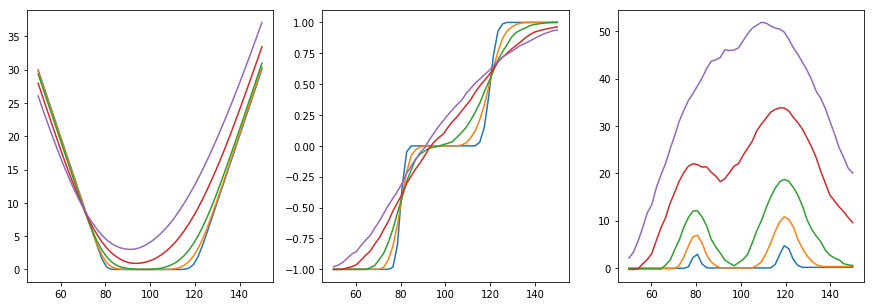

In [23]:
pathLength    = 12
numberOfPaths = 1000

S0         = 100
K          = [100,20]
t2m        = 1.0
rfr        = 0.05
vol        = 0.2
oType      = 'Straddle'
mySeed     = 15  #None
calcGreeks = True

parameterRange1 = np.linspace(0.5*K[0],1.5*K[0],50)
parameterRange2 = [0.01,0.05,0.15,0.5,1.0]
resultRangeA    = []
resultRangeB    = []
resultRangeC    = []
for y in parameterRange2:
    tmpResultRangeA = []
    tmpResultRangeB = []
    tmpResultRangeC = []
    for x in parameterRange1:
        S0  = x
        t2m = y
        output = bsMCPricer(S0,K,t2m,rfr,vol,numberOfPaths,pathLength,oType,mySeed,calcGreeks)
        tmpResultRangeA.append(output['price'])
        tmpResultRangeB.append(output['delta'])
        tmpResultRangeC.append(output['vega'])
    resultRangeA.append(tmpResultRangeA)
    resultRangeB.append(tmpResultRangeB)
    resultRangeC.append(tmpResultRangeC)

fig = plt.figure(figsize = (15,5))

ax1  = plt.subplot(1,3,1)
for result in resultRangeA:
    ax1 = plt.plot(parameterRange1, result)

ax2  = plt.subplot(1,3,2)
for result in resultRangeB:
    ax2 = plt.plot(parameterRange1, result)
    
ax3  = plt.subplot(1,3,3)
for result in resultRangeC:
    ax3 = plt.plot(parameterRange1, result)

0.01
0.05
0.15
0.5
1.0


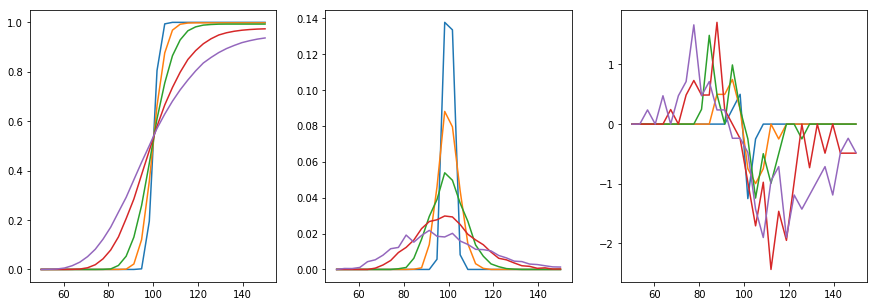

In [3]:
pathLength    = 12
numberOfPaths = 10000

S0         = 100
K          = [100,20]
t2m        = 1.0
rfr        = 0.05
vol        = 0.2
oType      = 'Binary'
mySeed     = 15  #None
calcGreeks = True

parameterRange1 = np.linspace(0.5*K[0],1.5*K[0],30)
parameterRange2 = [0.01,0.05,0.15,0.5,1.0]
resultRangeA    = []
resultRangeB    = []
resultRangeC    = []
for y in parameterRange2:
    print(y,end=' ')
    tmpResultRangeA = []
    tmpResultRangeB = []
    tmpResultRangeC = []
    for x in parameterRange1:
        #print(x,end=' ')
        S0  = x
        t2m = y
        output = bsMCPricer(S0,K,t2m,rfr,vol,numberOfPaths,pathLength,oType,mySeed,calcGreeks)
        tmpResultRangeA.append(output['price'])
        tmpResultRangeB.append(output['delta'])
        tmpResultRangeC.append(output['vega'])
    resultRangeA.append(tmpResultRangeA)
    resultRangeB.append(tmpResultRangeB)
    resultRangeC.append(tmpResultRangeC)

fig = plt.figure(figsize = (15,5))

ax1  = plt.subplot(1,3,1)
for result in resultRangeA:
    ax1 = plt.plot(parameterRange1, result)

ax2  = plt.subplot(1,3,2)
for result in resultRangeB:
    ax2 = plt.plot(parameterRange1, result)
    
ax3  = plt.subplot(1,3,3)
for result in resultRangeC:
    ax3 = plt.plot(parameterRange1, result)